# Introduction

The applications of recommender systems in businesses have become increasingly popular. Recommender systems apply various sources of information including demographics, social, and preferences to provide users with tailored recommended items. Moreover, the favoured technique for building recommender systems is Collaborative filtering. This technique is further divided into three main categories including Memory-Based, Model-Based, and Hybrid-BAsed. Therefore, as large businesses realise the advantages of recommending personalized items to users, the research for techniques, sources of information, and implementation grows. Netflix is among the big organisations interested in the expansion of recommmender system. The application of recommender systems at Netflix is widely known, however improvements are continiously being investigated to provide users with the best movie and series recommendations. Thus, this notebook aims to investigate the application of collaborative filtering techniques for Netflix.      

#### Which type of RecSys based on CF could Netflix user to provide the most accurate recommendations to users?

- What are the different type of RecSys based on CF?
- Which types could be used for Netflix' dataset?
- How do KNN and SVD compare?

# Importing

Importing the necessary libraries

In [646]:
import os
import pandas as pd
import numpy as np

import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors

# The following libraries are used to evaluate the performance of the models
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# As working with NaN values in matrices overwelmed the output with warnings 
# these warnings will be ignored.
import warnings
warnings.filterwarnings('ignore')

# Netflix Dataset

Code to append movieId to each record in all of the source files if this has not been executed earlier. This will allow all the source files to be loaded into a dataframe with one line of code and without having to add the movieId seperately before concatting the sourcefiles.

In [670]:
def format_netflix_source():
    x = 0
    string = ","+str(x)

    # Loop through each file in the directory
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as f:
            # Check if the first line of the first file already has been formatted
            # If yes the formatting will be skipped
            if(f.readlines()[0] == '1:,1\n'):
                print('Source is already formatted, continuing \n')
                return
            else:
                print('Started formatting source files \n')
                # Append a ',', movieId and \n (newline) to each line 
                file_lines = [''.join([x.strip(), string, '\n']) for x in f.readlines()]
        with open(os.path.join(directory, filename), 'w') as f:
            # Save the formatted file
            f.writelines(file_lines)
            print('Completed formatting source files')
    return

Creating the movie dataframe by concatting all the sourcefiles without their title (skiprows=1). Concluding with naming the columns.

In [675]:
def import_netflix_dataset():
    #
    directory = "/Users/vbraun/Downloads/training_set/"

    # 
    format_netflix_source()

    print('Started concatting all source files to DataFrame \n')
    # Importing all different files into one dataframe (including itemId)
    # As the files do not have a header and differ between each other 'header' = None and the first row will be skipped
    movie_df = pd.concat(pd.read_csv(os.path.join(directory, fname), skiprows=1,header=None) for fname in os.listdir(directory)).rename(columns={0:'userId',1:'rating',2:'date',3:'itemId'})
    print('Completed concatting all source files to DataFrame \n')

    # Dropping the date column as this is not relevant for this recommender system
    movie_df = movie_df.drop(columns='date')

    display(movie_df.head(5))

    return movie_df

### Data filtering

To allow for faster development a debugging variable is used. If debugging is True the dataset will only consist of the first 100 movies. For the final model, debugging will be set to False.

In order to filter the dataset based on activity and reduce the sparsity of the data, the data will be grouped and filtered based on movies and users. The datasets will show how many ratings each movie has gotten and how many rating each user has given.

To reduce the sparcity of data in the dataset, we will filter out the users that have rated fewer than 5% of the total amount of movies.

Finally, the movies that have been rated by fewer than 50 people will be filtered out of the dataset.

In [673]:
def filter_netflix_dataset(movie_df, debugging = True, required_rated_percentage = 0.05):
    # 
    if debugging == True:
        print('Debugging is set to True: limiting the dataset to the first 100 movies')
        filtered_movie_df = movie_df[movie_df['itemId'] <= 100]
    else:
        filtered_movie_df = movie_df
    print('Length of selected dataset: {0} \n'.format(len(filtered_movie_df)))

    # 
    filtered_movie_count = filtered_movie_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
    filtered_user_count = filtered_movie_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})
    # display(filtered_movie_count.head(3),filtered_user_count.head(3))

    print('Filtering out users that have rated less than {0}% of all items'.format(int(required_rated_percentage*100)))
    # Look if the userId exists when the total amount of items rated by a user (filtered_user_count['item_count']), divided by the total amount of movies (len(filtered_movie_count)' is bigger than the required_rated_percentage (default = 0.05)
    filtered_movie_df = filtered_movie_df[filtered_movie_df['userId'].isin(filtered_user_count[filtered_user_count['item_count']/len(filtered_movie_count) > required_rated_percentage]['userId'])]
    print('Length of filtered dataset: {0} \n'.format(len(filtered_movie_df)))

    print('Filtering out movies that have been rated by fewer than {0} users'.format(50))
    # 
    filtered_movie_df = filtered_movie_df[filtered_movie_df['itemId'].isin(filtered_movie_count[filtered_movie_count['user_count']>50]['itemId'])]
    print('Length of filtered dataset:',len(filtered_movie_df))
    return filtered_movie_df

In [672]:
netflix_df = import_netflix_dataset()

Source is already formatted, continuing
Started concatting all source files to DataFrame
Completed concatting all source files to DataFrame


,userId,rating,itemId
0,1488844,3,1
1,822109,5,1
2,885013,4,1
3,30878,4,1
4,823519,3,1


In [666]:
filtered_netflix_df = filter_netflix_dataset(netflix_df)

Debugging is set to True: only selecting the first 100 items
Length of selected dataset: 352771 

Filtering out users that have rated less than 5% of all items
Length of filtered dataset: 44209 

Filtering out movies that have been rated by fewer than 50 users
Length of filtered dataset: 44209


## Jester Dataset

In [520]:
jester_items = pd.read_csv(r'C:\Users\vbraun\Downloads\SDM-Datasets\jester_items.csv')
jester_ratings = pd.read_csv(r'C:\Users\vbraun\Downloads\SDM-Datasets\jester_ratings.csv')

In [ ]:
jester_df = jester_ratings.rename(columns={'jokeId':'itemId'})
jester_df['rating'] = jester_df['rating'] + 10

In [ ]:
jester_item_count = jester_df[['itemId','userId']].groupby('itemId').count().reset_index().rename(columns={'userId':'user_count'})
jester_user_count = jester_df[['itemId','userId']].groupby('userId').count().reset_index().rename(columns={'itemId':'item_count'})

In [ ]:
filtered_jester_df = jester_df[jester_df['userId'].isin(jester_user_count[jester_user_count['item_count']/len(jester_item_count) > 0.05]['userId'])]
filtered_jester_df = filtered_jester_df[filtered_jester_df['itemId'].isin(jester_item_count[jester_item_count['user_count']>20]['itemId'])]

## Dataset Selection

In [521]:
is_movie_dataset = True

if is_movie_dataset == True:
    filtered_df = filtered_movie_df
else:
    filtered_df = filtered_jester_df

# EDA

In [522]:
print('The filtered dataset has', filtered_df['userId'].nunique(), 'unique users')
print('The filtered dataset has', filtered_df['itemId'].nunique(), 'unique movies')
print('The filtered dataset has', filtered_df['rating'].nunique(), 'unique ratings')
print('The unique ratings are', sorted(filtered_df['rating'].unique()))

The filtered dataset has 5629 unique users
The filtered dataset has 100 unique movies
The filtered dataset has 5 unique ratings
The unique ratings are [1, 2, 3, 4, 5]


In [523]:
display(filtered_df.head(),filtered_df.tail())

,userId,rating,itemId
0,1488844,3,1
3,30878,4,1
7,1248029,3,1
18,1711859,4,1
20,1080361,3,1


,userId,rating,itemId
67,1639792,1,100
71,2349702,3,100
74,443447,4,100
76,428688,2,100
77,2634967,1,100


In [524]:
filtered_df.describe()

,userId,rating,itemId
count,4.420900e+04,44209.000000,44209.000000
mean,1.338604e+06,3.326585,48.804474
std,7.630206e+05,1.144595,25.333156
min,1.333000e+03,1.000000,1.000000
25%,6.749270e+05,3.000000,28.000000
50%,1.340377e+06,3.000000,46.000000
75%,2.004175e+06,4.000000,77.000000
max,2.648885e+06,5.000000,100.000000


In [525]:
print('Amount of NaN values in the dataset:',filtered_df.loc[lambda x: x.isnull().any(axis=1)].shape[0])

Amount of NaN values in the dataset: 0


The following graph shows for each movie (as a dot) what its mean rating is in comparison to the total amount of ratings. 

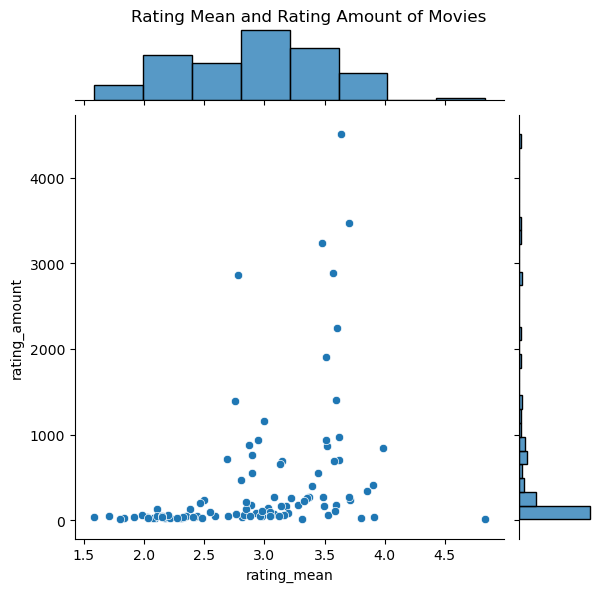

In [526]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_df.groupby('itemId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Movies")
plt.fig.subplots_adjust(top=0.95)

Notably, movies with low mean ratings have generally been rated a low number of times in relation to movies with a mean rating higher than 3.0.

The next graph shows the same variables as the graph seen above for each user. 

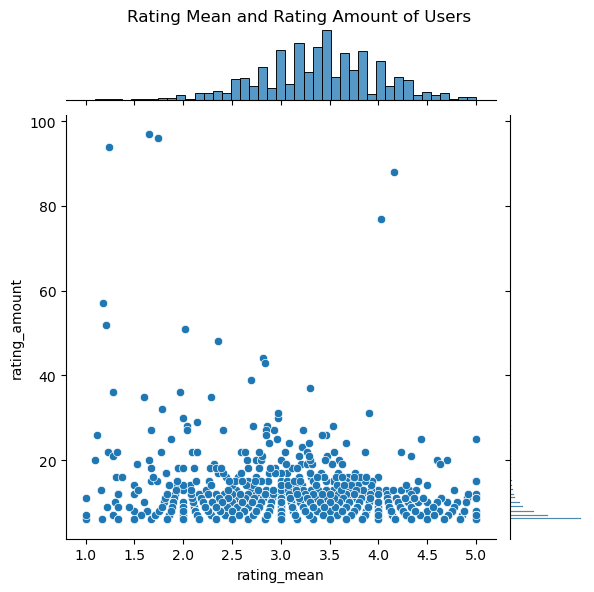

In [527]:
plt = sns.jointplot(x='rating_mean', y='rating_amount', data=filtered_df.groupby('userId').agg(rating_mean = ('rating', 'mean'), rating_amount = ('rating', 'count')).reset_index())
plt.fig.suptitle("Rating Mean and Rating Amount of Users")
plt.fig.subplots_adjust(top=0.95)

The graph for users show that there are several outliers of users that have rated many movies while having a low mean of their ratings. Additionally, the graph shows that mean of the rating mean approaches normality. 

# Singular Value Decomposition

Pivot the dataset into a matrix with index='userId', columns='itemId', values='rating' in order to later perform user-based collaborative filtering. Moreover, fill_value = 0 in order to remove NaN values and save them as 0. Finally, the matrix is directly stored as a sparse matrix to save memory, instead of first saving the entire matrix into memory. 

Scipy.sparse.linalg.svds was used to perform a partial singular value decomposition of a sparse matrix. This function allows us to specify 'k' which is the number of singular values and singular vectors that have to be computed. 

In [528]:
def calculate_svd_prediction(data, k = 5):
    # Performing the SVD matrix factorisation giving: u (m x r) orthogonal matrix, 
    # s (r x r) diagonal matrix, and vt(ransposed) (r x n) orthogonal matrix.
    u, s, vt = svds(data.toarray(), k = k)

    # A diagonal matrix has to be created for s in order to recreate a matrix from u, s, and vt
    s_diagonal = np.diag(s)

    # Recreate the matrix by performing matrix multiplications of u, s, and vt
    predictions = np.dot(np.dot(u, s_diagonal), vt)
    
    return predictions

In order to evaluate the performance of the recommendations following SVD we only need the $\hat{y}$ of existing $y$. Therefore, all other values will be filtered out of the prediction dataset by using pred[truth.nonzero()]. Afterwards we are able to evaluate the performance of our model by comparing $\hat{y}$ with their corresponding $y$. 

In [529]:
def evaluate_predictions(pred, truth):
    pred = pred[truth.nonzero()].flatten()
    truth = truth[truth.nonzero()].flatten()

    rmse = np.sqrt(mean_squared_error(pred,truth))
    mae = mean_absolute_error(pred,truth)
    
    return rmse, mae

# Hyper Parameter Tuning of SVD

Different k values lead to different predictions

We will perform hyperparameter tuning to find the k with the lowest rmse. For each k we will perform multiple iterations, in which a random sample of the data will be masked and used to calculate the rmse. The rmse of a k value will be the average rmse of all iterations of that k. 

In [631]:
def hyper_parameter_tuning_svd(iteration_amount = 10):
    results = []

    iterations = iteration_amount
    print('Calculating the average rmse over {0} iterations'.format(iterations))

    k_list = [1,2,3,4,5,6,7,8,9,10,20,30,50,80]

    for k in k_list:
        rmse_list = []
        for i in range(0,iterations):
            dataset_ex_masked, masked_data = train_test_split(filtered_df, test_size=.05)

            dataset_ex_masked_csr = csr_matrix(dataset_ex_masked.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
            masked_data_csr = csr_matrix(masked_data.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)

            rmse, mae = evaluate_predictions(hyper_svd(dataset_ex_masked_csr,k),masked_data_csr.toarray())
            
            rmse_list.append(rmse)
    
        results.append([k,(sum(rmse_list)/len(rmse_list))])
        print('For k = {0}, the average rmse = {1}'.format(k,(sum(rmse_list)/len(rmse_list))))

    best_parameters_svd = sorted(results, key=lambda x: x[1])[0]
    print('The rmse is lowest for k = {0} at = {1}'.format(best_parameters_svd[0],best_parameters_svd[1]))
    
    return best_parameters_svd
    

# SVD Recommendation

In [632]:

final_csr_matrix = csr_matrix(filtered_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
predictions = hyper_svd(final_csr_matrix,best_parameters_svd[0])

In [633]:
recommend_for_user = 650

user_pred_df = pd.DataFrame(predictions)
user_sel_pred_df = user_pred_df.loc[recommend_for_user].sort_values(ascending=False)

user_df = pd.DataFrame(final_csr_matrix.toarray())
selected = pd.DataFrame(user_df.loc[recommend_for_user])
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated items are: [16, 17, 25, 29, 54, 96]
82    1.525069
43    1.022864
27    0.892296
Name: 650, dtype: float64


# K Nearest Neighbors

In [634]:
sparse_matrix = csr_matrix(filtered_df.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
sparse_matrix.check_format

<bound method _cs_matrix.check_format of <5629x100 sparse matrix of type '<class 'numpy.float64'>'
	with 44209 stored elements in Compressed Sparse Row format>>

In [635]:
train_data, test_data = train_test_split(sparse_matrix, test_size=.30)
test_data, validation_data = train_test_split(test_data, test_size=.33)

1. Create NearestNeighbors model
1. Fit the model with train data
1. Use kneighbors to find the k amount of neighbors of the jokes in the test data
1. Calculate the prediction by taking the average score of the k most similar jokes
1. Evaluate the model by comparing the actual ratings with the predicted ratings

Algorithm is set at brute (force) because the inputdata is sparse

In [636]:
def create_knn_model(metric='cosine',k = 5,n_neighbors = 20,testdata=validation_data):
    knn_model = NearestNeighbors(metric=metric,algorithm='brute',n_neighbors=n_neighbors,n_jobs=-1)

    knn_model_fitted = knn_model.fit(train_data.toarray())
    distance, indices = knn_model_fitted.kneighbors(testdata.toarray(),k)

    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distance.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    knn_prediction = []
    for i, (idx, dist) in enumerate(raw_recommends):
        td = pd.DataFrame(train_data.toarray())
        sim_users = np.array(td[td.index.isin(idx)])
        sim_users[sim_users == 0] = np.nan
        average_rat = np.nan_to_num(np.nanmean(sim_users,axis=0))
        knn_prediction.append(average_rat)
    
    rmse, mae = evaluate_predictions(testdata.toarray(),np.array(knn_prediction))
    
    return rmse, knn_model_fitted, knn_prediction

# Hyper Parameter Tuning for KNN

In [637]:
n_neighbors = [5,10,20,50]
recommendation_amount = [3,5,10]
metric = ['euclidean','manhattan','cosine','minkowski']

hpt_results = []
for met in metric:
    for k in recommendation_amount:
        for n in n_neighbors:
            hpt_results.append([create_knn_model(metric=met, k=k,n_neighbors=n,testdata=validation_data)[0],met,k,n])
print(hpt_results)

[[2.594929803299141, 'euclidean', 3, 5], [2.594929803299141, 'euclidean', 3, 10], [2.594929803299141, 'euclidean', 3, 20], [2.594929803299141, 'euclidean', 3, 50], [2.5224806445541934, 'euclidean', 5, 5], [2.5224806445541934, 'euclidean', 5, 10], [2.5224806445541934, 'euclidean', 5, 20], [2.5224806445541934, 'euclidean', 5, 50], [2.44077708200596, 'euclidean', 10, 5], [2.44077708200596, 'euclidean', 10, 10], [2.44077708200596, 'euclidean', 10, 20], [2.44077708200596, 'euclidean', 10, 50], [2.7349015221926147, 'manhattan', 3, 5], [2.7349015221926147, 'manhattan', 3, 10], [2.7349015221926147, 'manhattan', 3, 20], [2.7349015221926147, 'manhattan', 3, 50], [2.6867615448407007, 'manhattan', 5, 5], [2.6867615448407007, 'manhattan', 5, 10], [2.6867615448407007, 'manhattan', 5, 20], [2.6867615448407007, 'manhattan', 5, 50], [2.6596296918387763, 'manhattan', 10, 5], [2.6596296918387763, 'manhattan', 10, 10], [2.6596296918387763, 'manhattan', 10, 20], [2.6596296918387763, 'manhattan', 10, 50], [

In [638]:
best_parameters_knn = sorted(hpt_results, key=lambda x: x[0])[0]
print(best_parameters)

[2.4038460040135923, 'euclidean', 10, 5]


In [639]:
best_knn_rmse, best_knn_model, best_knn_predictions = create_knn_model(metric=best_parameters_knn[1], k=best_parameters_knn[2],n_neighbors=best_parameters_knn[3],testdata = test_data)

print(rmse)

2.4334189646644457


In [640]:
recommend_for_user = 50

user_pred_df = pd.DataFrame(predictions)
user_sel_pred_df = user_pred_df.loc[recommend_for_user].sort_values(ascending=False)

user_df = pd.DataFrame(final_csr_matrix.toarray())
selected = pd.DataFrame(user_df.loc[recommend_for_user])
rated_movies = selected.loc[~(selected==0).all(axis=1)].index.values.tolist()

recommended_movies = user_sel_pred_df.loc[~user_sel_pred_df.index.isin(rated_movies)]

print('Rated items are:',rated_movies)
print(recommended_movies[:3])

Rated items are: [15, 17, 27, 57, 67, 87]
29    1.630473
47    1.303044
32    1.288816
Name: 50, dtype: float64


# Performance evaluation of SVD and KNN 

In order to answer the subquestion: "How do the KNN and SVD models compare?" we will compare compare the rmse of both models for the same dataset.

In [641]:
def best_svd_model():
    dataset_ex_masked, masked_data = train_test_split(filtered_df, test_size=.05)

    dataset_ex_masked_csr = csr_matrix(dataset_ex_masked.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)
    masked_data_csr = csr_matrix(masked_data.pivot_table(index='userId', columns='itemId', values='rating').fillna(0).values)

    rmse, mae = evaluate_predictions(hyper_svd(dataset_ex_masked_csr,k),masked_data_csr.toarray())
print(rmse)

3.332751597117029


In [642]:
rmse, model, predictions = create_knn_model(metric=best_parameters_knn[1], k=best_parameters_knn[2],n_neighbors=best_parameters_knn[3],testdata = test_data)

print(rmse)

2.409505818926267


#### Which type of RecSys based on CF could Netflix user to provide the most accurate recommendations to users?

- How do KNN and SVD compare?